In [146]:
import re
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

home = os.path.expanduser("~")
data_dir = os.path.join(home, 'Documents/semantic-robot/testing/results')

# solution = 'instance robot_1 robot|instance charging_station zone|instance unload_zone zone|instance shelf_1 zone|instance shelf_2 zone|instance pallet_1 pallet|predicate robot_at robot_1 charging_station|predicate pallet_at pallet_1 unload_zone|predicate pallet_not_moved pallet_1|predicate is_unload_zone unload_zone|predicate is_shelf_zone shelf_1|predicate is_shelf_zone shelf_2|goal pallet_at pallet_1 shelf_1|goal robot_at robot_1 shelf_2|'

### Extract necessary data

In [147]:
def extract_data(filename):
    with open(filename) as f:
        content = f.read()

    test_sets = re.findall(r'Test set #\s+:\s+(.+)', content)
    number_of_examples = re.findall(r'Number of examples\s+:\s+(.+)', content)
    inference_times = re.findall(r'Inference time \[s\]\s+:\s+(.+)', content)
    memory_usage = re.findall(r'GPU memory loaded \[MB\]\s+:\s+(.+)', content)
    input_size = re.findall(r'Model input size \[MB\]\s+:\s+(.+)', content)
    model = re.findall(r'Model\s+:\s+(.+)', content)
    sliced_output = re.findall(r'Sliced output\s+:\s+(.+)', content)
    solution = re.findall(r'Solution\s+:\s+(.+)', content)
    labeled = re.findall(r'Labeled\s+:\s+(.+)', content)

    return {
        'model': list(map(str, model)),
        'test_set': list(map(int, test_sets)),
        'num_examples': list(map(int, number_of_examples)),
        'sliced_output': list(map(str, sliced_output)),
        'solution': list(map(str, solution)),
        'inference_time': list(map(float, inference_times)),
        'memory_usage': list(map(float, memory_usage)),
        'input_size': list(map(float, input_size)),
        'labeled': list(map(str, labeled))
    }

### Read files of results from 4-bit, 8-bit, half and full precision for both labeled and unlabeled examples

In [148]:
num = 'final_'

data_4bit = extract_data(os.path.join(data_dir, num + 'mistral_results_4bit.txt'))
data_4bit_labeled = extract_data(os.path.join(data_dir, num + 'mistral_results_4bit_labeled.txt'))

# data_8bit = extract_data(os.path.join(data_dir, num + 'mistral_results_8bit.txt'))
# data_8bit_labeled = extract_data(os.path.join(data_dir, num + 'mistral_results_8bit_labeled.txt'))

# data_half_precision = extract_data(os.path.join(data_dir, num + 'mistral_results_half_precision.txt'))
# data_half_precision_labeled = extract_data(os.path.join(data_dir, num + 'mistral_results_half_precision_labeled.txt'))

# data_full_precision = extract_data(os.path.join(data_dir, num + 'mistral_results_full_precision.txt'))
# data_full_precision_labeled = extract_data(os.path.join(data_dir, num + 'mistral_results_full_precision_labeled.txt'))

df_4bit = pd.DataFrame(data_4bit)
df_4bit_labeled = pd.DataFrame(data_4bit_labeled)

# df_8bit = pd.DataFrame(data_8bit)
# df_8bit_labeled = pd.DataFrame(data_8bit_labeled)

# df_half_precision = pd.DataFrame(data_half_precision)
# df_half_precision_labeled = pd.DataFrame(data_half_precision_labeled)

# df_full_precision = pd.DataFrame(data_full_precision)
# df_full_precision_labeled = pd.DataFrame(data_full_precision_labeled)

### 4-bit unlabeled

In [149]:
inf_times = np.zeros(max(df_4bit['num_examples']))
mem_usages = np.zeros(max(df_4bit['num_examples']))
input_sizes = np.zeros(max(df_4bit['num_examples']))

sliced_outputs = []

for i in range(2, max(df_4bit['num_examples'])+1):
    idxs = df_4bit.loc[df_4bit['num_examples'] == i]
    
    inference_times = [float(x) for x in idxs['inference_time']]
    if inference_times:
        avg_inference_time = sum(inference_times) / len(inference_times)
    else:
        avg_inference_time = 0

    memory_usage = [float(x) for x in idxs['memory_usage']]
    if memory_usage:    
        avg_memory_usage = sum(memory_usage) / len(memory_usage)
    else:
        avg_memory_usage = 0

    input_size = [float(x) for x in idxs['input_size']]
    if input_size:    
        avg_input_size = sum(input_size) / len(input_size)
    else:
        avg_input_size = 0
    
    sliced_output = [str(x) for x in idxs['sliced_output']]
    sliced_outputs.append(sliced_output)

    inf_times[i-2] = avg_inference_time
    mem_usages[i-2] = avg_memory_usage
    input_sizes[i-2] = avg_input_size

sliced_outputs = list(map(list, zip(*sliced_outputs)))

solutions = []
for i in range(1, max(df_4bit['test_set'])+1):
    idxs = df_4bit.loc[df_4bit['test_set'] == i]
    first = idxs['solution'].iloc[0]
    solutions.append(str(first))

Denne delen er utkast til hvordan jeg kan automatisere det å sjekke hvor god mistral output er.

Til nå har jeg skilt ut alle instance-typer.

In [189]:
sols = solutions[0]

instances = sols.split('predicate')[0]
predicates = sols.split('goal ')[0].replace(instances, '')
goals = sols.replace(instances + predicates, '')

instances = instances.replace("|", " |")
predicates = predicates.replace("|", " |")
goals = goals.replace("|", " |")

instances_words = instances.split()
predicates_words = predicates.split()
goals_words = goals.split()

# iterate over the words in instances, predicates and goals and delete the char | where is is
for i in range(len(instances_words)):
    instances_words[i] = instances_words[i].replace("|", "")
for i in range(len(predicates_words)):
    predicates_words[i] = predicates_words[i].replace("|", "")
for i in range(len(goals_words)):
    goals_words[i] = goals_words[i].replace("|", "")

# removing instances and instance name to only keep the instance type
instances_types = instances_words[2::3]

In [192]:
instances_types

['robot', 'zone', 'zone', 'zone', 'zone', 'pallet']

### Write outputs to file for comparison

In [125]:
counter = 0
num_of_ex_list = []

with open('output_results.txt', 'w') as f:
    for i in range(len(sliced_outputs)):        
        for j in range(len(sliced_outputs[i])):
            instance_count_out = sliced_outputs[i][j].count('instance')
            predicate_count_out = sliced_outputs[i][j].count('predicate')
            goal_count_out = sliced_outputs[i][j].count('goal')

            instance_count_sol = solutions[i].count('instance')
            predicate_count_sol = solutions[i].count('predicate')
            goal_count_sol = solutions[i].count('goal')

            if instance_count_out==instance_count_sol and predicate_count_out==predicate_count_sol and goal_count_out==goal_count_sol:
                counter+=1
                num_of_ex_list.append(j+2)

            f.write(f'Test set {i+1} - number of examples {j+2}\n')
            f.write(f'{sliced_outputs[i][j]}\n')
            f.write(f'{solutions[i]}\n')
            f.write(f'instances: {instance_count_out}/{instance_count_sol} - predicate count: {predicate_count_out}/{predicate_count_sol} - goal count: {goal_count_out}/{goal_count_sol}\n\n')

In [126]:
# count the number of times each number of examples appears
num_of_ex_list = np.array(num_of_ex_list)
unique, counts = np.unique(num_of_ex_list, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 3  1]
 [ 5  3]
 [ 6  2]
 [ 8  3]
 [10  2]
 [11  1]
 [13  1]
 [14  3]
 [16  1]
 [19  1]
 [20  1]
 [23  1]
 [24  3]
 [25  1]
 [26  2]
 [28  1]
 [29  1]
 [30  2]
 [31  3]]


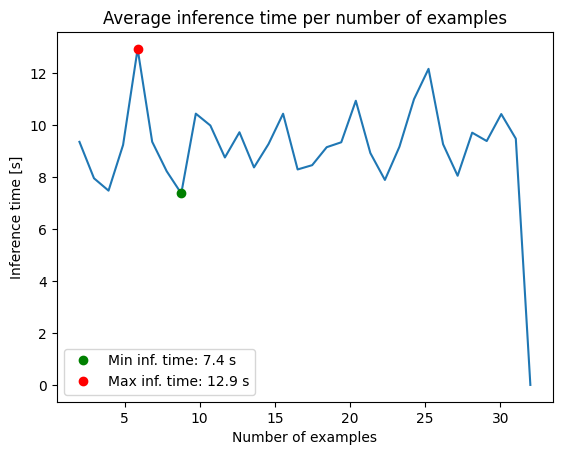

In [127]:
x = np.linspace(2, 32, len(inf_times))
plt.plot(x, inf_times)
plt.title('Average inference time per number of examples')
plt.xlabel('Number of examples')
plt.ylabel('Inference time [s]')

min_inf_time = min(x for x in inf_times if x != 0)
max_inf_time = max(inf_times)
min_inf_time_idx = np.where(inf_times == min_inf_time)
max_inf_time_idx = np.where(inf_times == max_inf_time)

plt.plot(x[min_inf_time_idx], min_inf_time, 'go', label=f'Min inf. time: {round(min_inf_time, 1)} s')
plt.plot(x[max_inf_time_idx], max_inf_time, 'ro', label=f'Max inf. time: {round(max_inf_time, 1)} s')
plt.legend()

plt.show()

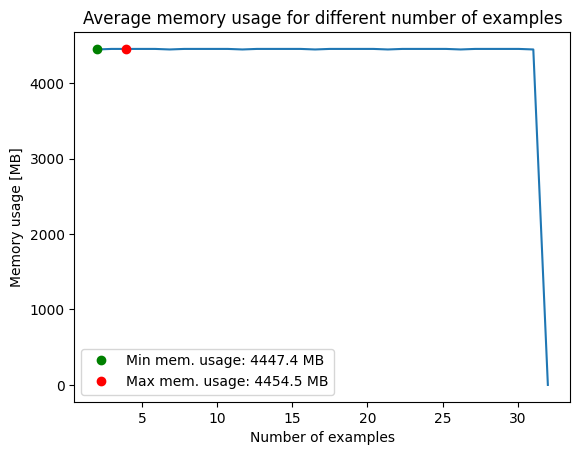

In [128]:
x = np.linspace(2, 32, len(mem_usages))
plt.plot(x, mem_usages)
plt.title('Average memory usage for different number of examples')
plt.xlabel('Number of examples')
plt.ylabel('Memory usage [MB]')

min_mem_usage = min(x for x in mem_usages if x != 0)
max_mem_usage = max(mem_usages)
min_mem_usage_idx = np.where(mem_usages == min_mem_usage)
max_mem_usage_idx = np.where(mem_usages == max_mem_usage)

plt.plot(x[min_mem_usage_idx[0]][random.randint(0, len(min_mem_usage_idx))], min_mem_usage, 'go', label=f'Min mem. usage: {round(min_mem_usage, 1)} MB')
plt.plot(x[max_mem_usage_idx[0]][random.randint(0, len(min_mem_usage_idx))], max_mem_usage, 'ro', label=f'Max mem. usage: {round(max_mem_usage, 1)} MB')
plt.legend()

plt.show()

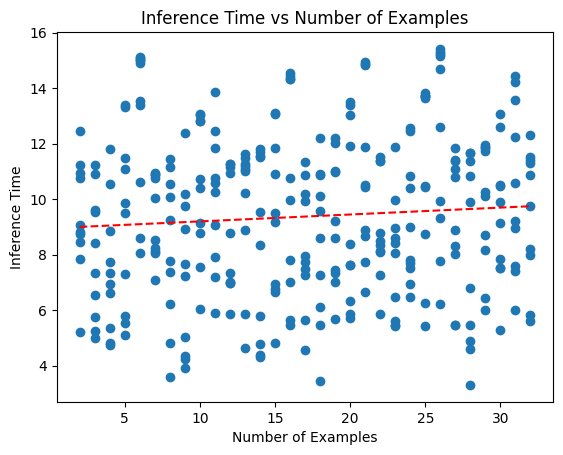

In [129]:
plt.scatter(data_4bit['num_examples'], data_4bit['inference_time'])
plt.xlabel('Number of Examples')
plt.ylabel('Inference Time')
plt.title('Inference Time vs Number of Examples')

z = np.polyfit(data_4bit['num_examples'], data_4bit['inference_time'], 1)
p = np.poly1d(z)
plt.plot(data_4bit['num_examples'], p(data_4bit['num_examples']), "r--")

plt.show()

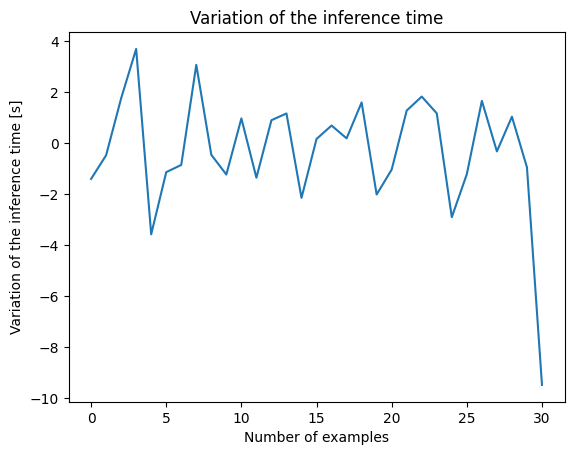

In [130]:

# compute the variation of the inference time
inf_time_variation = np.diff(inf_times)

plt.plot(inf_time_variation)
plt.title('Variation of the inference time')
plt.xlabel('Number of examples')
plt.ylabel('Variation of the inference time [s]')

plt.show()

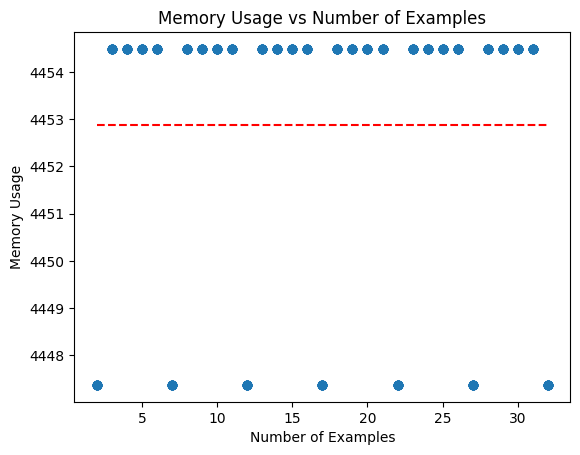

In [131]:
plt.scatter(data_4bit['num_examples'], data_4bit['memory_usage'])
plt.xlabel('Number of Examples')
plt.ylabel('Memory Usage')
plt.title('Memory Usage vs Number of Examples')

z = np.polyfit(data_4bit['num_examples'], data_4bit['memory_usage'], 1)
p = np.poly1d(z)
plt.plot(data_4bit['num_examples'], p(data_4bit['num_examples']), "r--")

plt.show()

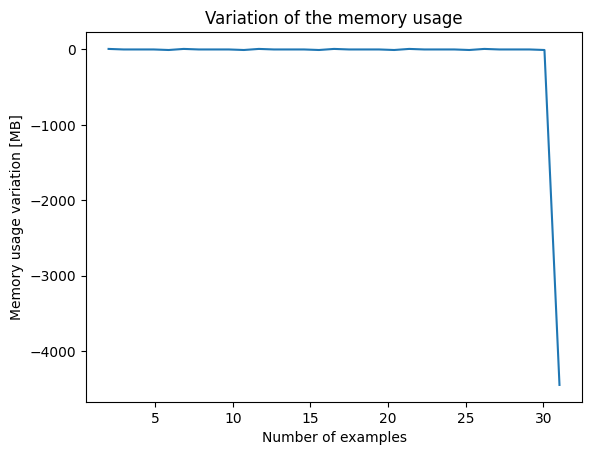

In [132]:
# compute the variation of the memory usage
mem_usages = np.array(mem_usages)
mem_usages_diff = np.diff(mem_usages)
plt.plot(x[:-1], mem_usages_diff)
plt.title('Variation of the memory usage')
plt.xlabel('Number of examples')
plt.ylabel('Memory usage variation [MB]')
plt.show()

### 4-bit labeled

### 8-bit unlabeled

### 8-bit labeled

### Half precision unlabeled

### Half precision labeled

### Full precision unlabeled

### Full precision labeled